# RFM 计算 Notebook

使用kaggle数据集 https://www.kaggle.com/datasets/ersany/online-retail-dataset/data  进行的 RFM 计算。

该数据包含许多业务场景常见场景，比如
- 退货
- 空值
- 运费类型
- 手工操作类型
- ...

需要做数据清洗才能获得能够用于计算RFM的干净数据


In [ ]:
## EDA 数据探索

In [1]:
import pandas as pd

df = pd.read_excel('data/Online Retail.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 数据质量检查和清洗：
1. 33% 的 CustomerID 是空值。如果要做客户相关分析，则无法进行，所以后续去掉这些行
2. Description 是空值问题不大，因为StockCode正确就可以
3. Quantity 包含负值和两个奇怪的值，（-80995，80995），这个后续处理应该去掉 【经过数据探索，这些负值一般为退货】
4. UnitPrice 包含负值，和一个极高的值38970，后面根据记录具体情况出来（因为 百分之99.9的记录都在206下方，所以需要检查38970是否是一个异常值 【经过删除customerid空值，负的UnitPrice也消除了】
5. 有多个类型为object的列，后面要转成字符串类型或其他对应类型
6. 
   

In [2]:
# 空值记录
df.isnull().sum()*100/df.count()

InvoiceNo       0.000000
StockCode       0.000000
Description     0.269033
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     33.203139
Country         0.000000
dtype: float64

In [3]:
# 查看数据分布，看看是否有不合理的地方
df.describe(percentiles=[0.001,0.9,0.95,0.999],include='all')

C:\Users\iniunet\AppData\Local\Temp\ipykernel_14768\3317329533.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(percentiles=[0.001,0.9,0.95,0.999],include='all')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,23260,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
0.1%,NaN,NaN,NaN,-96.000000,NaN,0.000000,12354.000000,NaN


In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [12]:
df_con = df.groupby(["Country"]).count()
df_con.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
Country,,,,,,,
Australia,1259,1259,1259,1259,1259,1259,1259
Austria,401,401,401,401,401,401,401
Bahrain,19,19,19,19,19,19,17
Belgium,2069,2069,2069,2069,2069,2069,2069
Brazil,32,32,32,32,32,32,32


### 数据清洗
1. 删除 CustomerID 为空的列
2. 

In [4]:
df.dropna(subset=['CustomerID'],inplace=True)

In [5]:
# 现在记录中应该没有空值了
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [6]:
df.describe(percentiles=[0.001,0.95,0.9999])

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
0.1%,-40.000000,0.120000,12354.000000
50%,5.000000,1.950000,15152.000000
95%,36.000000,8.500000,17905.000000
99.99%,1504.758000,1136.300000,18287.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
# 查看 Quantity 为负值的记录
df_neg_quantity = df[df.Quantity < 0 ]
df_neg_quantity.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


### quantity < 0 代表退货，计算 Recency 的时候需要找到 最后一条 非负值的 记录

In [8]:
# 查看 每列的 极值情况

print(df.sort_values('Quantity',ascending=True).head())
print(df.sort_values('Quantity',ascending=False).head())
print(df.sort_values('UnitPrice',ascending=True).head())
print(df.sort_values('UnitPrice',ascending=False).head())

       InvoiceNo StockCode                          Description  Quantity  \
540422   C581484     23843          PAPER CRAFT , LITTLE BIRDIE    -80995   
61624    C541433     23166       MEDIUM CERAMIC TOP STORAGE JAR    -74215   
4287     C536757     84347  ROTATING SILVER ANGELS T-LIGHT HLDR     -9360   
160145   C550456     21108   FAIRY CAKE FLANNEL ASSORTED COLOUR     -3114   
160144   C550456     21175          GIN + TONIC DIET METAL SIGN     -2000   

               InvoiceDate  UnitPrice  CustomerID         Country  
540422 2011-12-09 09:27:00       2.08     16446.0  United Kingdom  
61624  2011-01-18 10:17:00       1.04     12346.0  United Kingdom  
4287   2010-12-02 14:23:00       0.03     15838.0  United Kingdom  
160145 2011-04-18 13:08:00       2.10     15749.0  United Kingdom  
160144 2011-04-18 13:08:00       1.85     15749.0  United Kingdom  
       InvoiceNo StockCode                        Description  Quantity  \
540421    581483     23843        PAPER CRAFT , LITTLE

### 删除 unitprice = 0 的数据行，不会影响 RFM 计算

In [9]:
df.count()

InvoiceNo      406829
StockCode      406829
Description    406829
Quantity       406829
InvoiceDate    406829
UnitPrice      406829
CustomerID     406829
Country        406829
dtype: int64

In [10]:
# 删除 unitprice = 0
df = df[df['UnitPrice'] != 0]
df.count()

InvoiceNo      406789
StockCode      406789
Description    406789
Quantity       406789
InvoiceDate    406789
UnitPrice      406789
CustomerID     406789
Country        406789
dtype: int64

### 探索 StockCode

In [11]:
df_StockCode = df.groupby(['StockCode']).count()
df_StockCode.head()


,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
StockCode,,,,,,,
10002,49,49,49,49,49,49,49
10080,21,21,21,21,21,21,21
10120,30,30,30,30,30,30,30
10125,64,64,64,64,64,64,64
10133,125,125,125,125,125,125,125


### 删除所有 StockCode = 'POST' 纪录

In [12]:
df = df[df.StockCode != 'POST']
df.count()

InvoiceNo      405593
StockCode      405593
Description    405593
Quantity       405593
InvoiceDate    405593
UnitPrice      405593
CustomerID     405593
Country        405593
dtype: int64

### 探索 StockCode = 'M' 视为手工补发纪录，需要进行删除

In [13]:
df = df[df.StockCode !='M']
df.count()

InvoiceNo      405134
StockCode      405134
Description    405134
Quantity       405134
InvoiceDate    405134
UnitPrice      405134
CustomerID     405134
Country        405134
dtype: int64

In [14]:
df.describe(include='all')

C:\Users\iniunet\AppData\Local\Temp\ipykernel_14768\2884002236.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,405134.0,405134,405134,405134.000000,405134,405134.000000,405134.000000,405134
unique,21880.0,3682,3894,NaN,20200,NaN,NaN,37
top,576339.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom
freq,542.0,2077,2070,NaN,543,NaN,NaN,361386
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.062241,NaN,2.979255,15294.842825,NaN
std,NaN,NaN,NaN,248.392086,NaN,8.795575,1710.090165,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,0.001000,12346.000000,NaN
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,13969.000000,NaN


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405134 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    405134 non-null  object        
 1   StockCode    405134 non-null  object        
 2   Description  405134 non-null  object        
 3   Quantity     405134 non-null  int64         
 4   InvoiceDate  405134 non-null  datetime64[ns]
 5   UnitPrice    405134 non-null  float64       
 6   CustomerID   405134 non-null  float64       
 7   Country      405134 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.8+ MB


In [16]:
df['InvoiceNo'] = df['InvoiceNo'].astype(pd.StringDtype())
df['StockCode'] = df['StockCode'].astype(pd.StringDtype())
df['Description'] = df['Description'].astype(pd.StringDtype())
df['Country'] = df['Country'].astype(pd.StringDtype())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405134 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    405134 non-null  string        
 1   StockCode    405134 non-null  string        
 2   Description  405134 non-null  string        
 3   Quantity     405134 non-null  int64         
 4   InvoiceDate  405134 non-null  datetime64[ns]
 5   UnitPrice    405134 non-null  float64       
 6   CustomerID   405134 non-null  float64       
 7   Country      405134 non-null  string        
dtypes: datetime64[ns](1), float64(2), int64(1), string(4)
memory usage: 27.8 MB


# RFM 计算

In [17]:
from datetime import timedelta

# 找到最新交易日 和参考日期
latest_date = df.InvoiceDate.max()
print(latest_date)
reference_date = latest_date + timedelta(days=1)
print(reference_date)

2011-12-09 12:50:00
2011-12-10 12:50:00


## 计算 Recency

In [18]:
# 先去掉 退货的交易 Quantity < 0 

df_R = df[df.Quantity > 0]
df_R.describe()

,Quantity,UnitPrice,CustomerID
count,396501.000000,396501.000000,396501.000000
mean,13.007581,2.914297,15301.388269
std,179.604255,7.225062,1709.741155
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16801.000000
max,80995.000000,1599.260000,18287.000000


In [89]:
df_R.groupby(['CustomerID']).count()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
CustomerID,,,,,,,
12346.0,1,1,1,1,1,1,1
12347.0,182,182,182,182,182,182,182
12348.0,27,27,27,27,27,27,27
12349.0,72,72,72,72,72,72,72
12350.0,16,16,16,16,16,16,16
...,...,...,...,...,...,...,...
18280.0,10,10,10,10,10,10,10
18281.0,7,7,7,7,7,7,7
18282.0,12,12,12,12,12,12,12


In [19]:
recency_df = df_R.groupby(['CustomerID'])['InvoiceDate'].agg(Last_Purchased_Date='max').reset_index()
recency_df.head()

,CustomerID,Last_Purchased_Date
0,12346.0,2011-01-18 10:01:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


In [20]:
recency_df['Recency'] = (reference_date - recency_df['Last_Purchased_Date'])
recency_df['Recency'] = recency_df['Recency'].dt.days
recency_df.head()

,CustomerID,Last_Purchased_Date,Recency
0,12346.0,2011-01-18 10:01:00,326
1,12347.0,2011-12-07 15:52:00,2
2,12348.0,2011-09-25 13:13:00,75
3,12349.0,2011-11-21 09:51:00,19
4,12350.0,2011-02-02 16:01:00,310


### R 评分，1-5分

In [21]:
recency_df['R_Score']=pd.qcut(recency_df['Recency'],q=5,labels=[5,4,3,2,1])
recency_df.head()

,CustomerID,Last_Purchased_Date,Recency,R_Score
0,12346.0,2011-01-18 10:01:00,326,1
1,12347.0,2011-12-07 15:52:00,2,5
2,12348.0,2011-09-25 13:13:00,75,2
3,12349.0,2011-11-21 09:51:00,19,4
4,12350.0,2011-02-02 16:01:00,310,1


In [22]:
recency_df.groupby(['R_Score']).count()


,CustomerID,Last_Purchased_Date,Recency
R_Score,,,
5,867,867,867
4,902,902,902
3,860,860,860
2,839,839,839
1,867,867,867


## 计算 Frequency

In [52]:
freqency_df = df_R.groupby(['CustomerID']).agg(freqency=('InvoiceNo', 'nunique')).reset_index()
freqency_df.head()

,CustomerID,freqency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [53]:
freqency_df['F_score'] = pd.qcut(freqency_df['freqency'],q=5)

ValueError: Bin edges must be unique: array([  1.,   1.,   2.,   3.,   5., 206.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

在使用pd.qcut进行分桶评分是，发现有大量的frequency = 1的值，导致q=5的分桶失败，所以对尝试对frequency = 1 的F_Score 赋予 1，然后对其他部分进行4分桶

In [54]:
freqency_df.describe()

,CustomerID,freqency
count,4335.000000,4335.000000
mean,15299.372549,4.248212
std,1721.813812,7.646024
min,12346.000000,1.000000
25%,13812.500000,1.000000
50%,15298.000000,2.000000
75%,16778.500000,5.000000
max,18287.000000,206.000000


对 交易次数为 1 的所有记录，F_Score = 1，交易次数为 2 的记录， F_Score = 2

In [55]:
freqency_df['F_Score'] = 0
freqency_df.head()


,CustomerID,freqency,F_Score
0,12346.0,1,0
1,12347.0,7,0
2,12348.0,4,0
3,12349.0,1,0
4,12350.0,1,0


In [56]:
freqency_df.loc[freqency_df['freqency'] == 1,['F_Score']] = 1
freqency_df.loc[freqency_df['freqency'] == 2,['F_Score']] = 2
freqency_df.head()

,CustomerID,freqency,F_Score
0,12346.0,1,1
1,12347.0,7,0
2,12348.0,4,0
3,12349.0,1,1
4,12350.0,1,1


接下来对其余的购买次数进行 q=3 的分桶

In [60]:
freqency_df_rest = freqency_df[freqency_df.F_Score == 0]
freqency_df_rest.head()

,CustomerID,freqency,F_Score
2335,12347.0,7,0
2336,12348.0,4,0
2337,12352.0,7,0
2338,12356.0,3,0
2339,12359.0,4,0


In [50]:
print(freqency_df.count())
print(freqency_df_rest.count())

CustomerID    4335
freqency      4335
F_Score       4335
dtype: int64
CustomerID    2000
freqency      2000
F_Score       2000
dtype: int64


   CustomerID  freqency  F_Score
0     12346.0         1        1
1     12349.0         1        1
2     12350.0         1        1
3     12353.0         1        1
4     12354.0         1        1
5     12355.0         1        1
6     12357.0         1        1
7     12358.0         2        2
8     12361.0         1        1
9     12363.0         2        2
<bound method DataFrame.count of       CustomerID  freqency  F_Score
0        12346.0         1        1
1        12349.0         1        1
2        12350.0         1        1
3        12353.0         1        1
4        12354.0         1        1
...          ...       ...      ...
4330     18263.0         3        0
4331     18272.0         6        0
4332     18273.0         3        0
4333     18283.0        16        0
4334     18287.0         3        0

[4335 rows x 3 columns]>


In [61]:
freqency_df_rest['F_Score'] = pd.qcut(freqency_df_rest['freqency'],q=3,labels=[3,4,5])
freqency_df_rest.head(10)

C:\Users\iniunet\AppData\Local\Temp\ipykernel_14768\2116300164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freqency_df_rest['F_Score'] = pd.qcut(freqency_df_rest['freqency'],q=3,labels=[3,4,5])


,CustomerID,freqency,F_Score
2335,12347.0,7,4
2336,12348.0,4,3
2337,12352.0,7,4
2338,12356.0,3,3
2339,12359.0,4,3
2340,12360.0,3,3
2341,12362.0,10,5
2342,12364.0,4,3
2343,12370.0,4,3
2344,12372.0,3,3


In [62]:
freqency_df = pd.concat([freqency_df[freqency_df.F_Score > 0],freqency_df_rest],ignore_index=True)
print(freqency_df.head(10))
print(freqency_df.count)

   CustomerID  freqency  F_Score
0     12346.0         1        1
1     12349.0         1        1
2     12350.0         1        1
3     12353.0         1        1
4     12354.0         1        1
5     12355.0         1        1
6     12357.0         1        1
7     12358.0         2        2
8     12361.0         1        1
9     12363.0         2        2
<bound method DataFrame.count of       CustomerID  freqency  F_Score
0        12346.0         1        1
1        12349.0         1        1
2        12350.0         1        1
3        12353.0         1        1
4        12354.0         1        1
...          ...       ...      ...
4330     18263.0         3        3
4331     18272.0         6        4
4332     18273.0         3        3
4333     18283.0        16        5
4334     18287.0         3        3

[4335 rows x 3 columns]>


In [63]:
freqency_df.groupby(['F_Score']).count()

,CustomerID,freqency
F_Score,,
1,1505,1505
2,830,830
3,898,898
4,548,548
5,554,554


## 计算消费金额 Monetary

Monetary 需要考虑 退货的影响，分笔金额 = Quantity x UnitPrice， 再进行sum，所以要使用原有的df（包含负值 Quantity）

In [65]:
df['Amount']=df['Quantity'] * df['UnitPrice']
df[df.Quantity < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96


In [73]:
monetary_df = df.groupby(['CustomerID']).agg(Monetary = ('Amount','sum')).reset_index()
# monetary_df.loc[monetary_df.Monetary==0,'Monetary'].count()
monetary_df.loc[monetary_df.Monetary<0,'Monetary'] = 0
monetary_df.loc[monetary_df.Monetary==0,'Monetary'].count()

37

In [78]:
monetary_df['M_Score'] =  pd.qcut(monetary_df['Monetary'],q=5,labels=[1,2,3,4,5])
monetary_df.head(10)
monetary_df.groupby(['M_Score']).count()

,CustomerID,Monetary
M_Score,,
1,873,873
2,872,872
3,872,872
4,872,872
5,873,873


# 最终 RFM 评分表

In [85]:
recency_df=recency_df[['CustomerID','R_Score']]
freqency_df=freqency_df[['CustomerID','F_Score']]
monetary_df = monetary_df[['CustomerID','M_Score']]

In [97]:
Final_RFM = pd.merge(
    recency_df,
    freqency_df,
    on='CustomerID',
    how='outer'
)

Final_RFM = pd.merge(
    Final_RFM,
    monetary_df,
    on='CustomerID',
    how='outer'
)

Final_RFM.head()
Final_RFM.info()
Final_RFM.dropna()
Final_RFM['R_Score']=Final_RFM['R_Score'].astype(pd.Int8Dtype())
Final_RFM['F_Score']=Final_RFM['F_Score'].astype(pd.Int8Dtype())
Final_RFM['M_Score']=Final_RFM['M_Score'].astype(pd.Int8Dtype())

Final_RFM['RFM']= Final_RFM['R_Score'] + Final_RFM['F_Score'] + Final_RFM['M_Score']
Final_RFM.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4362 entries, 0 to 4361
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CustomerID  4362 non-null   float64 
 1   R_Score     4335 non-null   category
 2   F_Score     4335 non-null   float64 
 3   M_Score     4362 non-null   category
dtypes: category(2), float64(2)
memory usage: 111.2 KB


,CustomerID,R_Score,F_Score,M_Score,RFM
0,12346.0,1,1,1,3
1,12347.0,5,4,5,14
2,12348.0,2,3,4,9
3,12349.0,4,1,4,9
4,12350.0,1,1,2,4


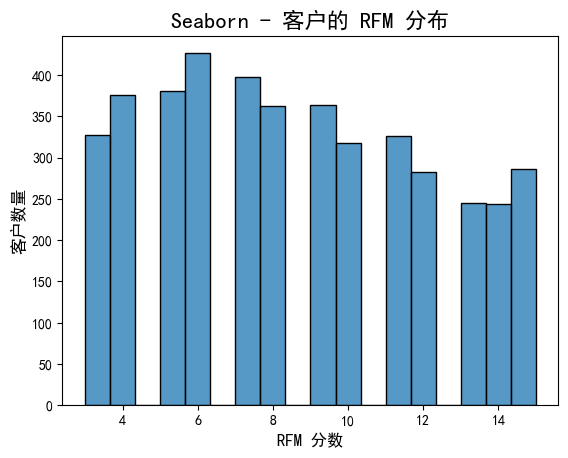

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# matplotlib 上查看中文需要设置
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS'] # 尝试多个，以防第一个失败
plt.rcParams['font.serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False # 解决负号 '-' 显示为方块的问题

sns.histplot(Final_RFM['RFM'])

plt.title('Seaborn - 客户的 RFM 分布', fontsize=16)
plt.xlabel('RFM 分数', fontsize=12)
plt.ylabel('客户数量', fontsize=12)
plt.show()